# Solution to Part 1 of the Major Assignment

In [1]:
!pip install tensorflow_io

     |████████████████████████████████| 23.4 MB 341 kB/s 


In [2]:
import os

from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_io as tfio
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.utils import shuffle

## Import the speech commands dataset

In [3]:
dataset_links = {'train_data': 'http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz',
                 'test_data': 'http://download.tensorflow.org/data/speech_commands_test_set_v0.02.tar.gz'}

In [4]:
for key in dataset_links:
    tf.keras.utils.get_file(key+'.tar.gz',
                            dataset_links[key],
                            cache_dir='./',
                            cache_subdir='datasets/'+key,
                            extract=True)

112574464/112563277 [==============================] - 1s 0us/step


In [5]:
# Perform os.walk to list all the files in our dataset and the
# corresponding labels.

train_data_paths = []
for folder, labels, samples in os.walk('./datasets/train_data/'):
    for sample in samples:
        if sample[-3:] == 'wav':
            train_data_paths.append([folder+'/'+sample, folder[22:]])

In [6]:
# Convert the list of files and labels to a DataFrame for further
# analysis
df = pd.DataFrame(train_data_paths, columns=['paths', 'labels'])

# Remove _background_noise_ recordings from the samples
df = df.drop(df[df['labels'] =='_background_noise_'].index)

df.head()

,paths,labels
0,./datasets/train_data/no/4c6944d6_nohash_1.wav,no
1,./datasets/train_data/no/da93deb7_nohash_1.wav,no
2,./datasets/train_data/no/39ec87ac_nohash_0.wav,no
3,./datasets/train_data/no/b49caed3_nohash_3.wav,no
4,./datasets/train_data/no/f6617a86_nohash_1.wav,no


In [7]:
# Make sure only audio files are listed in our data frame.
all(df['paths'].apply(lambda row: row[-3:]=='wav'))

True

In [8]:
categories = df['labels'].unique()
print("number of classes = {}".format(len(categories)))
print(categories)

number of classes = 35
['no' 'dog' 'sheila' 'six' 'learn' 'visual' 'marvin' 'eight' 'house'
 'backward' 'zero' 'two' 'five' 'on' 'left' 'go' 'nine' 'follow' 'off'
 'seven' 'three' 'wow' 'up' 'cat' 'yes' 'bird' 'down' 'bed' 'forward'
 'four' 'happy' 'one' 'right' 'stop' 'tree']


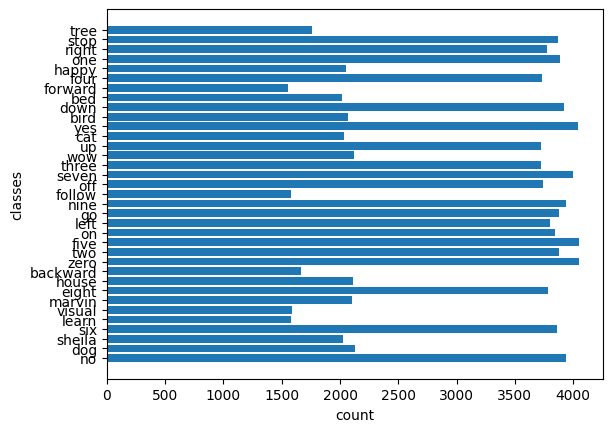

In [9]:
# Check the distribution of samples among classes.
plt.rcdefaults()
fig, ax = plt.subplots()

count = [(df['labels'] == cat).sum() for cat in categories]

ax.barh(categories, count)
ax.set_ylabel('classes')
ax.set_xlabel('count')

plt.show()

In [10]:
# Vectorize the labels by creating a dictionary as follows:
labels_dict = {categories[i]:i for i in range(len(categories))}
labels_lookup = {y:x for x,y in labels_dict.items()}

# Shuffle the data before splitting it
df = df.sample(frac=1)

In [90]:
df.reset_index(inplace=True)

## Prepare datasets

In [11]:
# Audio import function with padding
def load_audio(filepath):
    """Takes the path of a wav audio file as input and creates
    a numpy array of shape (16000) as output. The input file
    needs to sample rate=16000. The expected duration is 1s,
    shorter samples are padded at the end while longer samples
    are cropped at 1s."""
    audio = tfio.audio.AudioIOTensor(filepath)
    audio_rate = int(audio.rate)
    assert audio_rate == 16000
    audio = audio.to_tensor().numpy().reshape((-1)) / 32767.0
    audio = audio.astype(dtype="float32")
    len = audio.shape[0]
    # Padding
    if len == 16000:
        return audio
    elif len < 16000:
        return np.concatenate([audio, 
                               np.zeros(shape=(16000-len),
                                        dtype="float32")], 
                              axis=0)
    else:
        return audio[0:16000]


# The dataset class used to feed data to our model during training and evaluation.
class audio_gen(keras.utils.Sequence):
    def __init__(self, file_paths, labels,
                 batch_size=128, shape=(16000,1),
                 shuffle_on_epoch_end=True):
        # Initialization
        super().__init__()
        self.shape = shape
        self.batch_size = batch_size
        self.labels = labels
        self.paths = file_paths
        self.n_channels = shape[-1]
        self.n_classes = max(labels)+1
        self.shuffle = shuffle_on_epoch_end
        self.on_epoch_end()
    
    def __len__(self):
        return int(np.floor(len(self.paths) / self.batch_size))
    
    def __getitem__(self, idx):
        batch_paths = self.paths[self.batch_size * idx: 
                                 self.batch_size * (idx+1)]
        batch_labels = self.labels[self.batch_size * idx:
                                   self.batch_size * (idx+1)]
        batch_samples = np.zeros(shape=(0, self.shape[0]), 
                                 dtype='float32')
        for path in batch_paths:
            batch_samples = np.concatenate([batch_samples, [load_audio(path)]], 
                                           axis=0)
        return batch_samples, np.array(batch_labels, dtype='int')

    def on_epoch_end(self):
        # suffle the dataset after each epoch
        if self.shuffle:
            self.paths, self.labels = shuffle(self.paths, self.labels)

In [12]:
train_paths = np.array(df['paths'])[:90000]
train_labels = np.array([labels_dict[x] for x in df['labels']])[0:90000]

valid_paths = np.array(df['paths'])[90000:100000]
valid_labels = np.array([labels_dict[x] for x in df['labels']])[90000:100000]

test_paths = np.array(df['paths'])[100000:]
test_labels = np.array([labels_dict[x] for x in df['labels']])[100000:]

In [13]:
train_gen = audio_gen(train_paths, train_labels)
valid_gen = audio_gen(valid_paths, valid_labels)
test_gen = audio_gen(test_paths, test_labels)

## A Conv2D NN model using spectrograms

In [14]:
def get_spectrogram(audio_tensor):
    return tfio.audio.spectrogram(audio_tensor,
                                  nfft=512,
                                  window=256,
                                  stride=128)

# Human speech frequency range is 80-260Hz
def mel_spectrogram(audio_tensor):
    return tfio.audio.melscale(get_spectrogram(audio_tensor),
                               rate=16000,
                               mels=128,
                               fmin=0,
                               fmax=8000)


def dbscale_spectrogram(audio_tensor):
    return tfio.audio.dbscale(mel_spectrogram(audio_tensor),
                              top_db=80)/60.0

def mdb_spectrogram(audio_tensor, p=10):
    return tfio.audio.freq_mask(dbscale_spectrogram(audio_tensor), param=p)

In [37]:
# Augmentation parameter which controls the masking layer.
a_p = 10
num_classes = len(categories)

inputs = keras.Input(shape=(16000,))
x = layers.Lambda(lambda waveform: dbscale_spectrogram(waveform))(inputs)
x = layers.Reshape((125, 128, 1))(x)
x = layers.Conv2D(32, 4, 1, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(64, 4, 1, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(128, 4, 1)(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(256, 4, 1, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(512, 2, 1, activation='relu')(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
y = layers.Dense(num_classes, activation='softmax')(x)

model_Conv2D_35 = keras.Model(inputs = inputs, outputs = y)

model_Conv2D_35.summary()

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 16000)]           0         
                                                                 
 lambda_14 (Lambda)          (None, 125, 128)          0         
                                                                 
 reshape_14 (Reshape)        (None, 125, 128, 1)       0         
                                                                 
 conv2d_45 (Conv2D)          (None, 122, 125, 32)      544       
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 61, 62, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_46 (Conv2D)          (None, 58, 59, 64)        32832     
                                                          

In [38]:
model_Conv2D_35.compile(optimizer="adam",
                        loss="sparse_categorical_crossentropy",
                         metrics=['accuracy'])

callback = keras.callbacks.ModelCheckpoint("./models/Conv2D_35.h5",
                                           monitor='val_loss',
                                           save_weights_only=True,
                                           save_best_only=True)

# model_Conv2D_35.load_weights("./models/Conv2D_35.h5")

In [19]:
!mkdir models

In [39]:
history = model_Conv2D_35.fit(train_gen, validation_data=valid_gen,
                              epochs=100, callbacks=[callback])

Epoch 1/100
703/703 [==============================] - 185s 242ms/step - loss: 1.6061 - accuracy: 0.5473 - val_loss: 1.0276 - val_accuracy: 0.7089
Epoch 2/100
703/703 [==============================] - 161s 229ms/step - loss: 0.6134 - accuracy: 0.8242 - val_loss: 0.4915 - val_accuracy: 0.8656
Epoch 3/100
703/703 [==============================] - 160s 227ms/step - loss: 0.4806 - accuracy: 0.8624 - val_loss: 0.4889 - val_accuracy: 0.8643
Epoch 4/100
703/703 [==============================] - 160s 227ms/step - loss: 0.4192 - accuracy: 0.8799 - val_loss: 0.5548 - val_accuracy: 0.8448
Epoch 5/100
703/703 [==============================] - 159s 227ms/step - loss: 0.3732 - accuracy: 0.8918 - val_loss: 0.3744 - val_accuracy: 0.8941
Epoch 6/100
703/703 [==============================] - 158s 225ms/step - loss: 0.3411 - accuracy: 0.9003 - val_loss: 0.3162 - val_accuracy: 0.9088
Epoch 7/100
703/703 [==============================] - 156s 222ms/step - loss: 0.3169 - accuracy: 0.9078 - val_loss: 0

KeyboardInterrupt: ignored

In [ ]:
# Plot the loss function for the training data and validation data

history_dict = history.history
loss_values = history_dict["loss"]
start = 1
val_loss_values = history_dict["val_loss"]
epochs = range(start, len(loss_values) + 1)
plt.plot(epochs, loss_values[start-1:], "bo", label="Training loss")
plt.plot(epochs, val_loss_values[start-1:], "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [41]:
model_Conv2D_35.load_weights("./models/Conv2D_35_val94.h5")
model_Conv2D_35.evaluate(test_gen)

45/45 [==============================] - 18s 397ms/step - loss: 0.2348 - accuracy: 0.9358


[0.2347920536994934, 0.9357638955116272]

### Transfer to the digits classification case

In [43]:
digits_dict = {'zero':0, 'one':1, 'two':2, 
               'three':3, 'four':4, 'five':5,
               'six':6, 'seven':7, 'eight':8,
               'nine':9}

In [93]:
digits_index = []
for digit in digits_dict.keys():
    digits_index = digits_index + list(df[df['labels']==digit].index)
df_digits = df.loc[digits_index]

In [94]:
print(df_digits['labels'].unique())
print(len(df_digits))

['zero' 'one' 'two' 'three' 'four' 'five' 'six' 'seven' 'eight' 'nine']
38908


In [98]:
df_digits.sort_index(inplace=True)

In [108]:
digits_train_paths = np.array(df_digits['paths'])[:34000]
digits_train_labels = np.array([digits_dict[x] for x in df_digits['labels']])[0:34000]

digits_valid_paths = np.array(df_digits['paths'])[34000:37000]
digits_valid_labels = np.array([digits_dict[x] for x in df_digits['labels']])[34000:37000]

digits_test_paths = np.array(df_digits['paths'])[37000:]
digits_test_labels = np.array([digits_dict[x] for x in df_digits['labels']])[37000:]

In [109]:
digits_train_gen = audio_gen(digits_train_paths, digits_train_labels)
digits_valid_gen = audio_gen(digits_valid_paths, digits_valid_labels)
digits_test_gen = audio_gen(digits_test_paths, digits_test_labels)

In [102]:
#inputs = keras.Input(shape=(16000,))
#x = layers.Lambda(lambda waveform: dbscale_spectrogram(waveform))(inputs)
#x = layers.Reshape((125, 128, 1))(x)
#x = layers.Conv2D(32, 4, 1, activation='relu')(x)
#x = layers.MaxPooling2D(2)(x)
#x = layers.Conv2D(64, 4, 1, activation='relu')(x)
#x = layers.MaxPooling2D(2)(x)
#x = layers.Conv2D(128, 4, 1)(x)
#x = layers.BatchNormalization()(x)
#x = layers.ReLU()(x)
#x = layers.MaxPooling2D(2)(x)
#x = layers.Conv2D(256, 4, 1, activation='relu')(x)
#x = layers.MaxPooling2D(2)(x)
#x = layers.Conv2D(512, 2, 1, activation='relu')(x)
#x = layers.GlobalAveragePooling2D()(x)
#x = layers.Dropout(0.5)(x)

z = layers.Dense(128, activation='relu')(x)
z = layers.Dense(10, activation='softmax')(z)

model_Conv2D_10 = keras.Model(inputs = inputs, outputs = z)

In [103]:
for layer in model_Conv2D_10.layers[:-3]:
    layer.trainable=False

model_Conv2D_10.summary()

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 16000)]           0         
                                                                 
 lambda_14 (Lambda)          (None, 125, 128)          0         
                                                                 
 reshape_14 (Reshape)        (None, 125, 128, 1)       0         
                                                                 
 conv2d_45 (Conv2D)          (None, 122, 125, 32)      544       
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 61, 62, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_46 (Conv2D)          (None, 58, 59, 64)        32832     
                                                          

In [110]:
model_Conv2D_10.compile(optimizer="adam",
                        loss="sparse_categorical_crossentropy",
                         metrics=['accuracy'])

callback = keras.callbacks.ModelCheckpoint("./models/Conv2D_10.h5",
                                           monitor='val_loss',
                                           save_weights_only=True,
                                           save_best_only=True)

history = model_Conv2D_10.fit(digits_train_gen, validation_data=digits_valid_gen,
                              epochs=20, callbacks=[callback])

Epoch 1/20
265/265 [==============================] - 64s 233ms/step - loss: 0.2143 - accuracy: 0.9401 - val_loss: 0.0952 - val_accuracy: 0.9704
Epoch 2/20
265/265 [==============================] - 55s 206ms/step - loss: 0.0800 - accuracy: 0.9747 - val_loss: 0.0835 - val_accuracy: 0.9721
Epoch 3/20
265/265 [==============================] - 54s 203ms/step - loss: 0.0694 - accuracy: 0.9777 - val_loss: 0.0782 - val_accuracy: 0.9759
Epoch 4/20
265/265 [==============================] - 55s 206ms/step - loss: 0.0657 - accuracy: 0.9774 - val_loss: 0.0744 - val_accuracy: 0.9749
Epoch 5/20
265/265 [==============================] - 53s 199ms/step - loss: 0.0616 - accuracy: 0.9793 - val_loss: 0.0804 - val_accuracy: 0.9732
Epoch 6/20
265/265 [==============================] - 53s 199ms/step - loss: 0.0622 - accuracy: 0.9791 - val_loss: 0.0778 - val_accuracy: 0.9755
Epoch 7/20
265/265 [==============================] - 53s 199ms/step - loss: 0.0552 - accuracy: 0.9813 - val_loss: 0.0869 - val_ac

KeyboardInterrupt: ignored

In [112]:
model_Conv2D_10.load_weights("./models/Conv2D_10_val975.h5")
model_Conv2D_10.evaluate(digits_test_gen)

14/14 [==============================] - 4s 265ms/step - loss: 0.0977 - accuracy: 0.9715


[0.09773997962474823, 0.9715401530265808]